In [16]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from IPython.display import display

pd.set_option("display.max_columns", None)

In [17]:
cwd = Path().resolve()

if (cwd / "notebooks").exists():
    ROOT = cwd
elif (cwd.name == "notebooks"):
    ROOT = cwd.parent
else:
    ROOT = cwd

train = pd.read_csv(ROOT / "data/train.csv")
test = pd.read_csv(ROOT / "data/test.csv")

print(train.shape, test.shape)
train

(891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


#### Survival distribution:
#### ~38% survivors

In [18]:
train["Survived"].value_counts(normalize=True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

#### Numeric features:
#### Pclass should be recategorized as a categorical col
#### Parch (# of parents/children onboard) is ordinal, can consider bucketing but may leave as-is
#### SibSp (# of siblings/spouses onboard) is ordinal, can consider bucketing but may leave as-is

In [19]:
train.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


<Axes: xlabel='Age', ylabel='Count'>

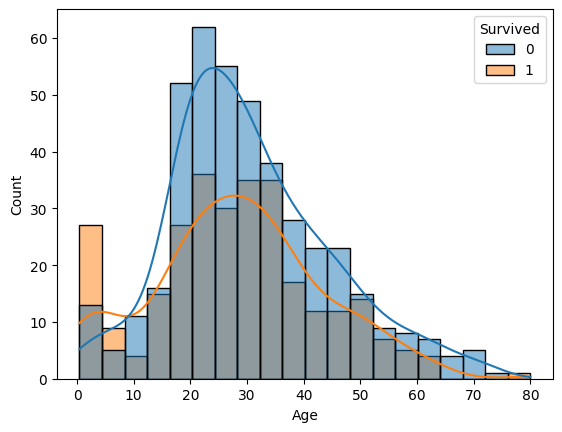

In [20]:
sns.histplot(train, x="Age", hue="Survived", bins=20, kde=True)


<Axes: xlabel='Fare', ylabel='Count'>

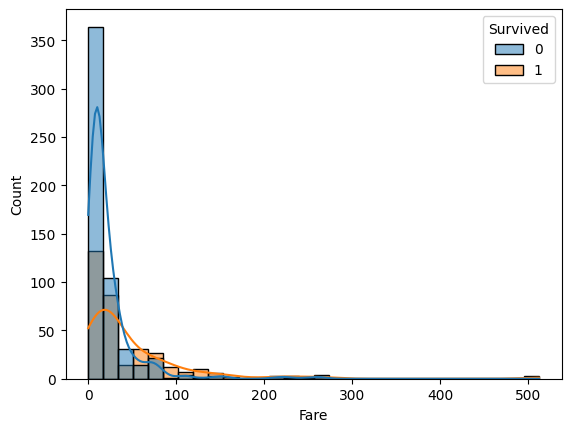

In [21]:
sns.histplot(train, x="Fare", hue="Survived", bins=30, kde=True)

<Axes: xlabel='Sex', ylabel='Count'>

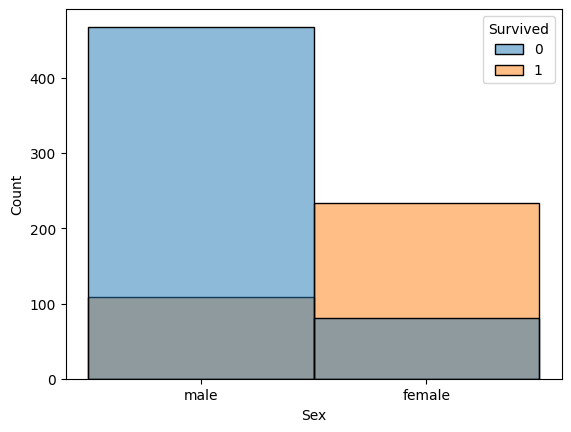

In [38]:
sns.histplot(train, x="Sex", hue="Survived", bins=20, kde=False)

#### Categorical columns including the Pclass column. A number of these are high cardinality. Cabin will be examined later.

In [24]:
cat_cols = train.select_dtypes(include=["object", "category"]).columns.tolist()
cat_cols.append("Pclass")

for col in cat_cols:
    print(f"{col}: {train[col].nunique()} unique values")

Name: 891 unique values
Sex: 2 unique values
Ticket: 681 unique values
Cabin: 147 unique values
Embarked: 3 unique values
Pclass: 3 unique values


In [ ]:
low_card_cols = [c for c in cat_cols if train[c].nunique() < 10]
high_card_cols = [c for c in cat_cols if c not in low_card_cols]
low_card_cols, high_card_cols

(['Sex', 'Embarked'], ['Name', 'Ticket', 'Cabin'])

#### Sex has a strong relationship with survival. Embarked is weak when isolated on its own.

In [28]:
for c in low_card_cols:
    print(train.groupby(c)["Survived"].mean())
    print("\n")

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64




### Name is high cardinality but generally follows a "Lastname, Title. Firstname" format. Title can be extracted and may provide insight

In [33]:
train["Title"] = train["Name"].str.extract(r",\s*([^\.]+)\.")
train["Title"].value_counts()

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Mme               1
Don               1
Lady              1
Sir               1
Capt              1
the Countess      1
Jonkheer          1
Name: count, dtype: int64

#### Low count categories should be bucketed to prevent overfitting

In [ ]:
title_map = {
    "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs",
    "Lady": "Rare", "the Countess": "Rare", "Capt": "Rare",
    "Col": "Rare", "Don": "Rare", "Dr": "Rare", "Major": "Rare",
    "Rev": "Rare", "Sir": "Rare", "Jonkheer": "Rare"
}
train["Title"] = train["Title"].replace(title_map)
train["Title"].value_counts()

Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64

#### Title is a strong feature

In [37]:
train.groupby("Title")["Survived"].mean()

Title
Master    0.575000
Miss      0.702703
Mr        0.156673
Mrs       0.793651
Rare      0.347826
Name: Survived, dtype: float64

### Examining mssing values
#### 3 Features with missing values:

In [ ]:
train.isna().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0
Ticket           0
dtype: int64

#### Cabin is sparsely populated. Age is missing 20% and may correlate with class & survival, first pass with median. Embarked will be imputed with most common.

In [ ]:
train.isna().mean().sort_values(ascending=False)

Cabin          0.771044
Age            0.198653
Embarked       0.002245
PassengerId    0.000000
Name           0.000000
Pclass         0.000000
Survived       0.000000
Sex            0.000000
Parch          0.000000
SibSp          0.000000
Fare           0.000000
Ticket         0.000000
dtype: float64

#### Cabin meaningfully contributes to survival rate

In [ ]:
train["cabinFlag"] = train["Cabin"].notna().astype(int)
train.groupby("cabinFlag")["Survived"].mean()

cabinFlag
0    0.299854
1    0.666667
Name: Survived, dtype: float64

#### Cabin has 147 different possible values but appears to be grouped by Deck letter

In [ ]:
c = train["Cabin"].dropna().unique()
c.shape[0], c

(147,
 array(['C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
        'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
        'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
        'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
        'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
        'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
        'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
        'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
        'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104',
        'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30',
        'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22',
        'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20',
        'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126',
        'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C

#### There is some insight provided by deck but some decks have few records which may cause unnecessary noise. To consider grouping into a "Rare" bucket value. To revisit later to see if simplified group encoding improves validation accuracy.

In [ ]:

train["Deck"] = train["Cabin"].dropna().str[0]
display(
    "Deck proportions:",
    train["Deck"].value_counts(normalize=True).sort_values(ascending=False),
    "Deck survival rate and count:",
    train.groupby("Deck")["Survived"].agg(["mean", "count"])
)

'Deck proportions:'

Deck
C    0.289216
B    0.230392
D    0.161765
E    0.156863
A    0.073529
F    0.063725
G    0.019608
T    0.004902
Name: proportion, dtype: float64

'Deck survival rate and count:'

,mean,count
Deck,,
A,0.466667,15
B,0.744681,47
C,0.593220,59
D,0.757576,33
E,0.750000,32
F,0.615385,13
G,0.500000,4
T,0.000000,1
